In [1]:
import os
import sys
print(os.getcwd())
sys.path.append("../WanPy")

from pythtb import *
import numpy as np
from wpythtb import Bloch, K_mesh, Wannier, Model
%load_ext line_profiler

/Users/treycole/Repos/WanPy/profiling


In [2]:
def Haldane(delta, t, t2):
    lat=[[1, 0],[0.5, np.sqrt(3)/2]]
    orb=[[1/3, 1/3],[2/3, 2/3]]

    model = tb_model(2, 2, lat, orb)

    model.set_onsite([-delta, delta], mode='reset')

    for lvec in ([0, 0], [-1, 0], [0, -1]):
        model.set_hop(t, 0, 1, lvec, mode='reset')
        model.set_hop(t, 0, 1, lvec, mode='reset')

    for lvec in ([1, 0], [-1, 1], [0, -1]):
        model.set_hop(t2*1j, 0, 0, lvec, mode='reset')
        model.set_hop(t2*-1j, 1, 1, lvec, mode='reset')

    return model

def Haldane2(delta, t, t2):
    lat=[[1, 0],[0.5, np.sqrt(3)/2]]
    orb=[[1/3, 1/3],[2/3, 2/3]]

    model = Model(2, 2, lat, orb)

    model.set_onsite([-delta, delta], mode='reset')

    for lvec in ([0, 0], [-1, 0], [0, -1]):
        model.set_hop(t, 0, 1, lvec, mode='reset')
        model.set_hop(t, 0, 1, lvec, mode='reset')

    for lvec in ([1, 0], [-1, 1], [0, -1]):
        model.set_hop(t2*1j, 0, 0, lvec, mode='reset')
        model.set_hop(t2*-1j, 1, 1, lvec, mode='reset')

    return model

In [3]:
hal = Haldane(1, 1, 1)
hal2 = Haldane2(1, 1, 1)

In [4]:
k_mesh = K_mesh(hal2, 10, 10)
full_mesh = k_mesh.gen_k_mesh(endpoint=True)
eig1 = hal.solve_all(full_mesh)
eig2 = hal2.solve_ham(full_mesh)
np.allclose(eig1, eig2.T)

True

In [5]:
full_mesh.shape

(100, 2)

In [6]:
ham1 = hal2._gen_ham(full_mesh[0])
ham_2 = hal2.get_ham(full_mesh[0])
print(np.allclose(ham1, ham_2))

True


In [7]:
%lprun -f hal.solve_all hal.solve_all(full_mesh)

Timer unit: 1e-09 s

Total time: 0.020019 s
File: /Users/treycole/miniforge3/envs/rutgers/lib/python3.10/site-packages/pythtb.py
Function: solve_all at line 955

Line #      Hits         Time  Per Hit   % Time  Line Contents
   955                                               def solve_all(self,k_list=None,eig_vectors=False):
   956                                                   r"""
   957                                                   Solves for eigenvalues and (optionally) eigenvectors of the
   958                                                   tight-binding model on a given one-dimensional list of k-vectors.
   959                                           
   960                                                   .. note::
   961                                           
   962                                                      Eigenvectors (wavefunctions) returned by this
   963                                                      function and used throughout the cod

In [8]:
%lprun -f hal2.solve_ham hal2.solve_ham(full_mesh)

Timer unit: 1e-09 s

Total time: 0.008811 s
File: /Users/treycole/Repos/WanPy/profiling/../WanPy/wpythtb.py
Function: solve_ham at line 125

Line #      Hits         Time  Per Hit   % Time  Line Contents
   125                                               def solve_ham(self, k_arr, return_eigvecs=False):
   126         1     385000.0 385000.0      4.4          H_k = self.get_ham(k_arr)
   127                                           
   128         1          0.0      0.0      0.0          if self._nspin == 1:
   129         1          0.0      0.0      0.0              H_k_use = H_k
   130                                                   elif self._nspin == 2:
   131                                                       # index mapping is (i, a, j, b) -> (2i + a, 2j + b)
   132                                                       new_shape = H_k.shape[:-4] + (2*self._norb, 2*self._norb)
   133                                                       H_k_use = H_k.reshape(*new_shape)


In [9]:
# result1 = %timeit -o hal.solve_all(full_mesh)
# result1

In [10]:
# %timeit hal2.solve_ham(full_mesh)

In [ ]:
import time

nk_arr = np.arange(1, 100, 1)
Nk = np.zeros(nk_arr.shape[0])
results1 = np.zeros(nk_arr.shape[0])
results2 = np.zeros(nk_arr.shape[0])

for idx, nk in enumerate(nk_arr):
    k_mesh = K_mesh(hal2, nk, nk)
    flat_mesh = k_mesh.gen_k_mesh(endpoint=True)
    Nk[idx] = flat_mesh.shape[0]

    start = time.time()
    result1 = hal.solve_all(flat_mesh)
    stop = time.time()
    results1[idx] = start - stop

    start = time.time()
    result2 =  hal2.solve_ham(flat_mesh)
    stop = time.time()
    results2[idx] = start - stop

Text(0, 0.5, 'time (s)')

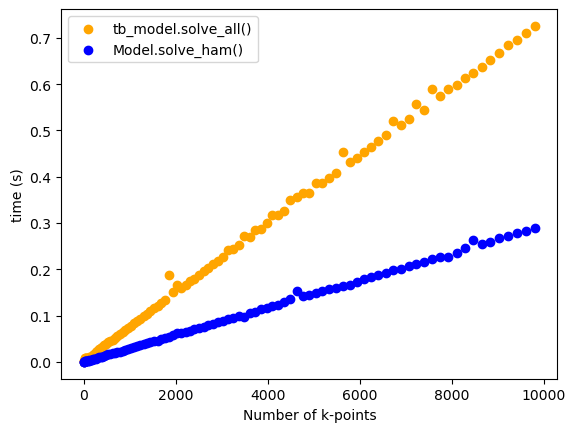

In [13]:
import matplotlib.pyplot as plt

plt.scatter(Nk, -results1, label="tb_model.solve_all()", c='orange')
plt.scatter(Nk, -results2, label="Model.solve_ham()", c='b')
plt.legend()
plt.xlabel("Number of k-points")
plt.ylabel("time (s)")

# plt.savefig("images/profiling_solve_ham.png")

In [ ]:
import time

nk_arr = np.arange(1, 100, 1)
results1 = np.zeros(nk_arr.shape[0])
results2 = np.zeros(nk_arr.shape[0])

for idx, nk in enumerate(nk_arr):
    # print(idx)
    k_mesh = K_mesh(hal2, nk, nk)
    flat_mesh = k_mesh.gen_k_mesh(endpoint=True)

    start = time.time()
    for k in flat_mesh:
        result1 = hal._gen_ham(k)
    stop = time.time()
    results1[idx] = start - stop

    start = time.time()
    result2 =  hal2.get_ham(flat_mesh)
    stop = time.time()
    results2[idx] = start - stop

Text(0, 0.5, 'time (s)')

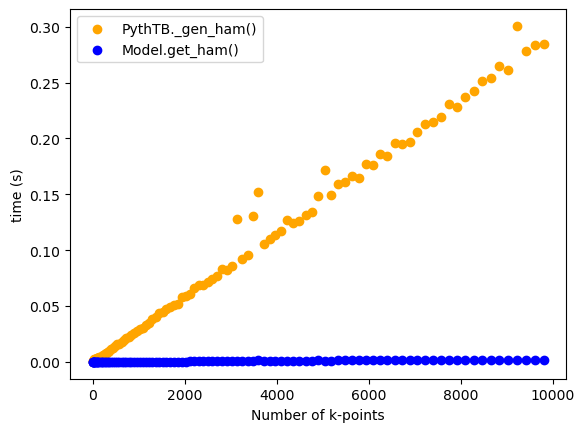

In [17]:
import matplotlib.pyplot as plt

plt.scatter(Nk, -results1, label="PythTB._gen_ham()", c='orange')
plt.scatter(Nk, -results2, label="Model.get_ham()", c='b')
plt.legend()
plt.xlabel("Number of k-points")
plt.ylabel("time (s)")

In [18]:
max_R = 5
dim_r = 4

sc_cands=[]
if dim_r==1:
    for i in range(-max_R,max_R+1):
        sc_cands.append(np.array([i]))
elif dim_r==2:
    for i in range(-max_R,max_R+1):
        for j in range(-max_R,max_R+1):
            sc_cands.append(np.array([i,j]))
elif dim_r==3:
    for i in range(-max_R,max_R+1):
        for j in range(-max_R,max_R+1):
            for k in range(-max_R,max_R+1):
                sc_cands.append(np.array([i,j,k]))
elif dim_r==4:
    for i in range(-max_R,max_R+1):
        for j in range(-max_R,max_R+1):
            for k in range(-max_R,max_R+1):
                for l in range(-max_R,max_R+1):
                    sc_cands.append(np.array([i,j,k,l]))

sc_cands

[array([-5, -5, -5, -5]),
 array([-5, -5, -5, -4]),
 array([-5, -5, -5, -3]),
 array([-5, -5, -5, -2]),
 array([-5, -5, -5, -1]),
 array([-5, -5, -5,  0]),
 array([-5, -5, -5,  1]),
 array([-5, -5, -5,  2]),
 array([-5, -5, -5,  3]),
 array([-5, -5, -5,  4]),
 array([-5, -5, -5,  5]),
 array([-5, -5, -4, -5]),
 array([-5, -5, -4, -4]),
 array([-5, -5, -4, -3]),
 array([-5, -5, -4, -2]),
 array([-5, -5, -4, -1]),
 array([-5, -5, -4,  0]),
 array([-5, -5, -4,  1]),
 array([-5, -5, -4,  2]),
 array([-5, -5, -4,  3]),
 array([-5, -5, -4,  4]),
 array([-5, -5, -4,  5]),
 array([-5, -5, -3, -5]),
 array([-5, -5, -3, -4]),
 array([-5, -5, -3, -3]),
 array([-5, -5, -3, -2]),
 array([-5, -5, -3, -1]),
 array([-5, -5, -3,  0]),
 array([-5, -5, -3,  1]),
 array([-5, -5, -3,  2]),
 array([-5, -5, -3,  3]),
 array([-5, -5, -3,  4]),
 array([-5, -5, -3,  5]),
 array([-5, -5, -2, -5]),
 array([-5, -5, -2, -4]),
 array([-5, -5, -2, -3]),
 array([-5, -5, -2, -2]),
 array([-5, -5, -2, -1]),
 array([-5, 

In [19]:
from itertools import product
from itertools import combinations_with_replacement as comb

sc_cands2 = [np.array(tup) for tup in product(*[range(-max_R, max_R + 1) for i in range(dim_r)])]
sc_cands2

[array([-5, -5, -5, -5]),
 array([-5, -5, -5, -4]),
 array([-5, -5, -5, -3]),
 array([-5, -5, -5, -2]),
 array([-5, -5, -5, -1]),
 array([-5, -5, -5,  0]),
 array([-5, -5, -5,  1]),
 array([-5, -5, -5,  2]),
 array([-5, -5, -5,  3]),
 array([-5, -5, -5,  4]),
 array([-5, -5, -5,  5]),
 array([-5, -5, -4, -5]),
 array([-5, -5, -4, -4]),
 array([-5, -5, -4, -3]),
 array([-5, -5, -4, -2]),
 array([-5, -5, -4, -1]),
 array([-5, -5, -4,  0]),
 array([-5, -5, -4,  1]),
 array([-5, -5, -4,  2]),
 array([-5, -5, -4,  3]),
 array([-5, -5, -4,  4]),
 array([-5, -5, -4,  5]),
 array([-5, -5, -3, -5]),
 array([-5, -5, -3, -4]),
 array([-5, -5, -3, -3]),
 array([-5, -5, -3, -2]),
 array([-5, -5, -3, -1]),
 array([-5, -5, -3,  0]),
 array([-5, -5, -3,  1]),
 array([-5, -5, -3,  2]),
 array([-5, -5, -3,  3]),
 array([-5, -5, -3,  4]),
 array([-5, -5, -3,  5]),
 array([-5, -5, -2, -5]),
 array([-5, -5, -2, -4]),
 array([-5, -5, -2, -3]),
 array([-5, -5, -2, -2]),
 array([-5, -5, -2, -1]),
 array([-5, 

In [13]:
np.allclose(sc_cands, sc_cands2)

True

In [18]:
hal2._gen_ham([0,0])

NameError: name 'hal2' is not defined